In [649]:
from math import nan, isnan

from pandas import read_excel, DataFrame, to_datetime, concat, Categorical, crosstab, Series
from scipy.stats import pearsonr, chi2_contingency
from scipy.stats.contingency import Chi2ContingencyResult
from seaborn import set_theme, displot, move_legend

In [650]:
df: DataFrame = read_excel("../data/06-study.xlsx", sheet_name="07 Survey", header=0)
df.rename(columns={
    "V1": "survey_id",
    "Zeitstempel": "datetime",
    "FrageNr": "qid",
    "Fachlichpersönlich": "background",
    "ObjektA": "object1",
    "ObjektB": "object2",
    "HastdudazuVorkenntnisse": "prior_knowledge",
    "WiewürdestdudichohneweitergehendeRechercheentscheiden": "decision_before_search_raw",
    "Wiesicherbistdudirdamit": "confidence_before_search",
    "HastdudiesesDokumentgelesen": "has_read_document1",
    "HastdudiesesDokumentgelesen_A": "has_read_document2",
    "HastdudiesesDokumentgelesen_B": "has_read_document3",
    "HastdudiesesDokumentgelesen_C": "has_read_document4",
    "WieentscheidestdudichnachdemdudieseDokumentegelesenhast": "decision_after_search_raw",
    "Wiesicherbistdudirjetztdamit": "confidence_after_search",
    "WelchesDokumentehathabendeineEntscheidungbeeinflusst": "influencing_documents",
    "WelchedieserAussagentrifftzu": "statements",
    "Relevanz_Dok1": "relevance_document1",
    "Relevanz_Dok2": "relevance_document2",
    "Relevanz_Dok3": "relevance_document3",
    "Relevanz_Dok4": "relevance_document4",
    "Haltung_Dok1": "stance_document1",
    "Haltung_Dok2": "stance_document2",
    "Haltung_Dok3": "stance_document3",
    "Haltung_Dok4": "stance_document4",
    "Qualität_Dok1": "quality_score_document1",
    "Qualität_Dok2": "quality_score_document2",
    "Qualität_Dok3": "quality_score_document3",
    "Qualität_Dok4": "quality_score_document4",
    "Qualität_Gesamt": "quality_score",
    "Entscheidung1A": "decision_before_search_object1",
    "Entscheidung1B": "decision_before_search_object2",
    "Entscheidung2A": "decision_after_search_object1",
    "Entscheidung2B": "decision_after_search_object2",
    "Beeinflussung1": "influence_document1",
    "Beeinflussung2": "influence_document2",
    "Beeinflussung3": "influence_document3",
    "Beeinflussung4": "influence_document4",
    "AussageDieRecherchehatmichinmeinerMeinungbestätigt": "statement_research_confirmed",
    "AussageIchkannmichmithilfedieserSuchergebnissebesserentscheiden": "statement_research_helped",
    "AussageDurchdieRecherchehabeichetwasNeueszudemThemagelernt": "statement_research_learned",
    "AussageDieSuchergebnissehabenmirnichtgeholfen": "statement_research_not_helped",
    "AussageIchwürdeandieserStellenochweiterrecherchieren": "statement_research_continue",
    "EntscheidungVorher": "stance_before_search",
    "EntscheidungVorherA": "stance_before_search_object1",
    "EntscheidungVorherB": "stance_before_search_object2",
    "EntscheidungNachher": "stance_after_search",
    "EntscheidungNachherA": "stance_after_search_object1",
    "EntscheidungNachherB": "stance_after_search_object2",
    "EntscheidungVorherX": "stance_before_search_none",
    "EntscheidungNachherX": "stance_after_search_none",
}, inplace=True)
df["background"] = df["background"].map({
    "fachlich": "factual",
    "persönlich": "subjective",
}).astype("category")
for doc in [1, 2, 3, 4]:
    df[f"has_partially_read_document{doc}"] = df[f"has_read_document{doc}"].map({
        "Ja": True,
        "Überflogen": True,
        "Nein": False,
    })
    df[f"has_fully_read_document{doc}"] = df[f"has_read_document{doc}"].map({
        "Ja": True,
        "Überflogen": False,
        "Nein": False,
    })
    df[f"stance_direction_document{doc}"] = df[f"stance_document{doc}"].map({
        1: "object1",
        2: "object1",
        3: "neutral",
        4: "object2",
        5: "object2",
        6: nan,
        nan: nan,
    }, na_action="ignore")
    df[f"stance_strength_document{doc}"] = df[f"stance_document{doc}"].map({
        1: 2,
        2: 1,
        3: 0,
        4: 1,
        5: 2,
        6: nan,
        nan: nan,
    }, na_action="ignore")
df["prior_knowledge"] = df["prior_knowledge"].map({
    "Ja": True,
    "Nein": False,
})
df["datetime"] = to_datetime(df["datetime"], format="%d.%m.%Y %H:%M:%S", utc=True)
df.drop(columns=[
    "datetime",
    "object1",
    "object2",
    "decision_before_search_raw",
    "decision_after_search_raw",
    "influencing_documents",
    "statements",
    "stance_before_search",
    "stance_before_search_object1",
    "stance_before_search_object2",
    "stance_before_search_none",
    "stance_after_search",
    "stance_after_search_object1",
    "stance_after_search_object2",
    "stance_after_search_none",
    "has_read_document1",
    "has_read_document2",
    "has_read_document3",
    "has_read_document4",
], inplace=True)
for col in [
    "decision_before_search_object1",
    "decision_before_search_object2",
    "decision_after_search_object1",
    "decision_after_search_object2",
    "influence_document1",
    "influence_document2",
    "influence_document3",
    "influence_document4",
    "statement_research_confirmed",
    "statement_research_helped",
    "statement_research_learned",
    "statement_research_not_helped",
    "statement_research_continue",
    "relevance_document1",
    "relevance_document2",
    "relevance_document3",
    "relevance_document4",
]:
    df[col] = df[col].astype(bool)
df["decision_before_search_none"] = ~df["decision_before_search_object1"] & ~df["decision_before_search_object2"]
df["decision_after_search_none"] = ~df["decision_after_search_object1"] & ~df["decision_after_search_object2"]
df["confidence_delta"] = df["confidence_after_search"] - df["confidence_before_search"]
df["decision_unchanged"] = (
        df["decision_before_search_object1"].eq(df["decision_after_search_object1"]) &
        df["decision_before_search_object2"].eq(df["decision_after_search_object2"]) &
        df["decision_before_search_none"].eq(df["decision_after_search_none"])
)
df["decision_changed"] = ~df["decision_unchanged"]
df["num_influencing_documents"] = df[[
    "influence_document1",
    "influence_document2",
    "influence_document3",
    "influence_document4",
]].sum(axis="columns")
df["relevance"] = df[[
    "relevance_document1",
    "relevance_document2",
    "relevance_document3",
    "relevance_document4",
]].mean(axis="columns")
df

,survey_id,qid,prior_knowledge,confidence_before_search,confidence_after_search,quality_score,quality_score_document1,quality_score_document2,quality_score_document3,quality_score_document4,...,has_fully_read_document4,stance_direction_document4,stance_strength_document4,decision_before_search_none,decision_after_search_none,confidence_delta,decision_unchanged,decision_changed,num_influencing_documents,relevance
0,0,28,False,3.0,3.0,0.322727,0.251515,0.372727,0.293939,0.372727,...,False,NaN,NaN,True,True,0.0,True,False,0,0.75
1,1,28,False,4.0,5.0,0.322727,0.251515,0.372727,0.293939,0.372727,...,True,NaN,NaN,False,True,1.0,False,True,2,0.75
2,2,28,False,3.0,3.0,0.322727,0.251515,0.372727,0.293939,0.372727,...,False,NaN,NaN,True,True,0.0,True,False,0,0.75
3,3,28,False,1.0,3.0,0.322727,0.251515,0.372727,0.293939,0.372727,...,False,NaN,NaN,True,True,2.0,True,False,0,0.75
4,4,28,True,3.0,6.0,0.322727,0.251515,0.372727,0.293939,0.372727,...,False,NaN,NaN,False,True,3.0,False,True,1,0.75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
549,549,10,False,6.0,4.0,0.503788,0.581818,0.739394,0.521212,0.172727,...,False,neutral,0.0,True,False,-2.0,False,True,3,0.75
550,550,10,False,5.0,6.0,0.503788,0.581818,0.739394,0.521212,0.172727,...,False,neutral,0.0,False,False,1.0,False,True,1,0.75
551,551,10,False,2.0,3.0,0.503788,0.581818,0.739394,0.521212,0.172727,...,False,neutral,0.0,False,False,1.0,True,False,2,0.75
552,552,10,True,4.0,6.0,0.503788,0.581818,0.739394,0.521212,0.172727,...,True,neutral,0.0,False,False,2.0,True,False,4,0.75


In [651]:
df_doc = concat([
    DataFrame([
        {
            "survey_id": row["survey_id"],
            "qid": row["qid"],
            "background": row["background"],
            "rank": rank,
            "decision_before_search_object1": row["decision_before_search_object1"],
            "decision_before_search_object2": row["decision_before_search_object2"],
            "decision_before_search_none": row["decision_before_search_none"],
            "confidence_before_search": row["confidence_before_search"],
            "decision_after_search_object1": row["decision_after_search_object1"],
            "decision_after_search_object2": row["decision_after_search_object2"],
            "decision_after_search_none": row["decision_after_search_none"],
            "confidence_after_search": row["confidence_after_search"],
            "decision_unchanged": row["decision_unchanged"],
            "decision_changed": row["decision_changed"],
            "confidence_delta": row["confidence_delta"],
            "has_fully_read_document": row[f"has_fully_read_document{rank}"],
            "has_partially_read_document": row[f"has_partially_read_document{rank}"],
            "influence_document": row[f"influence_document{rank}"],
            "prior_knowledge": row["prior_knowledge"],
            "quality_score": row["quality_score"],
            "quality_score_document": row[f"quality_score_document{rank}"],
            "relevance_document": row[f"relevance_document{rank}"],
            "stance_document": row[f"stance_document{rank}"],
            "stance_direction_document": row[f"stance_direction_document{rank}"],
            "stance_strength_document": row[f"stance_strength_document{rank}"],
            "statement_research_confirmed": row["statement_research_confirmed"],
            "statement_research_continue": row["statement_research_continue"],
            "statement_research_helped": row["statement_research_helped"],
            "statement_research_learned": row["statement_research_learned"],
            "statement_research_not_helped": row["statement_research_not_helped"],
        }
        for rank in [1, 2, 3, 4]
    ])
    for _, row in df.iterrows()
])
df_doc

,survey_id,qid,background,rank,decision_before_search_object1,decision_before_search_object2,decision_before_search_none,confidence_before_search,decision_after_search_object1,decision_after_search_object2,...,quality_score_document,relevance_document,stance_document,stance_direction_document,stance_strength_document,statement_research_confirmed,statement_research_continue,statement_research_helped,statement_research_learned,statement_research_not_helped
0,0,28,factual,1,False,False,True,3.0,False,False,...,0.251515,False,NaN,NaN,NaN,False,False,False,False,True
1,0,28,factual,2,False,False,True,3.0,False,False,...,0.372727,True,NaN,NaN,NaN,False,False,False,False,True
2,0,28,factual,3,False,False,True,3.0,False,False,...,0.293939,True,NaN,NaN,NaN,False,False,False,False,True
3,0,28,factual,4,False,False,True,3.0,False,False,...,0.372727,True,NaN,NaN,NaN,False,False,False,False,True
0,1,28,factual,1,True,False,False,4.0,False,False,...,0.251515,False,NaN,NaN,NaN,False,True,True,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3,552,10,factual,4,True,False,False,4.0,True,False,...,0.172727,True,3.0,neutral,0.0,True,False,True,False,False
0,553,10,factual,1,True,False,False,1.0,True,False,...,0.581818,True,3.0,neutral,0.0,False,False,False,True,False
1,553,10,factual,2,True,False,False,1.0,True,False,...,0.739394,True,3.0,neutral,0.0,False,False,False,True,False
2,553,10,factual,3,True,False,False,1.0,True,False,...,0.521212,False,2.0,object1,1.0,False,False,False,True,False


## Descriptive statistics

In [652]:
df_doc["background"].value_counts(dropna=False)

background
subjective    1120
factual       1096
Name: count, dtype: int64

In [653]:
df_doc[["has_fully_read_document", "has_partially_read_document"]].value_counts(dropna=False)

has_fully_read_document  has_partially_read_document
False                    True                           1108
True                     True                            658
False                    False                           450
Name: count, dtype: int64

In [654]:
df_doc[
    ["decision_before_search_none", "decision_before_search_object1", "decision_before_search_object2"]].value_counts(
    dropna=False)

decision_before_search_none  decision_before_search_object1  decision_before_search_object2
False                        True                            False                             996
True                         False                           False                             664
False                        False                           True                              556
Name: count, dtype: int64

In [655]:
df_doc[["decision_after_search_none", "decision_after_search_object1", "decision_after_search_object2"]].value_counts(
    dropna=False)

decision_after_search_none  decision_after_search_object1  decision_after_search_object2
False                       True                           False                            988
True                        False                          False                            836
False                       False                          True                             392
Name: count, dtype: int64

In [656]:
df_doc[["decision_before_search_none", "decision_after_search_none"]].value_counts(dropna=False)

decision_before_search_none  decision_after_search_none
False                        False                         1120
                             True                           432
True                         True                           404
                             False                          260
Name: count, dtype: int64

In [657]:
df_doc["decision_changed"].value_counts(dropna=False)

decision_changed
False    1364
True      852
Name: count, dtype: int64

## Histograms

/home/heinrich/Repositories/algorithmic-quality-decision-making/venv/lib/python3.11/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/heinrich/Repositories/algorithmic-quality-decision-making/venv/lib/python3.11/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/heinrich/Repositories/algorithmic-quality-decision-making/venv/lib/python3.11/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)

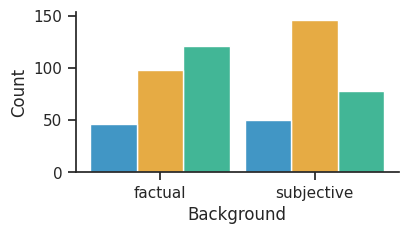

In [658]:
set_theme(
    style="ticks",
    palette="colorblind",
    font_scale=1.0,
    font="sans-serif",
)
df_plot = df.copy()
df_plot = df_plot[df_plot["confidence_delta"].notna()]
df_plot["confidence_changed"] = df_plot["confidence_delta"].map(
    lambda x: "no change" if x == 0 else "more confident" if x > 0 else "less confident")
df_plot["confidence_changed"] = Categorical(
    df_plot["confidence_changed"],
    categories=["less confident", "no change", "more confident"],
    ordered=True,
)
df_plot["background"] = Categorical(
    df_plot["background"],
    categories=["factual", "subjective"],
    ordered=True,
)
df_plot.sort_values(["confidence_changed", "background"], inplace=True)
plot = displot(
    df_plot,
    x="background",
    hue="confidence_changed",
    multiple="dodge",
    aspect=1.7,
    height=2.5,
    legend=False,
    shrink=0.9,
)
plot.set_xlabels(label="Background")
plot.savefig("../data/figures/histogram-confidence-change-background.pdf")
plot

/home/heinrich/Repositories/algorithmic-quality-decision-making/venv/lib/python3.11/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/heinrich/Repositories/algorithmic-quality-decision-making/venv/lib/python3.11/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/heinrich/Repositories/algorithmic-quality-decision-making/venv/lib/python3.11/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)

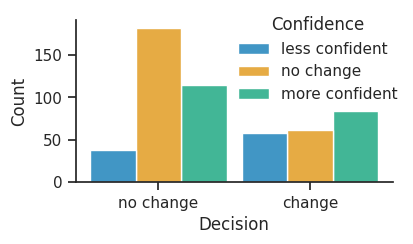

In [659]:
set_theme(
    style="ticks",
    palette="colorblind",
    font_scale=1.0,
    font="sans-serif",
)
df_plot = df.copy()
df_plot = df_plot[df_plot["confidence_delta"].notna()]
df_plot["confidence_changed"] = df_plot["confidence_delta"].map(
    lambda x: "no change" if x == 0 else "more confident" if x > 0 else "less confident")
df_plot["confidence_changed"] = Categorical(
    df_plot["confidence_changed"],
    categories=["less confident", "no change", "more confident"],
    ordered=True,
)
df_plot["decision_changed"] = df_plot["decision_changed"].map(
    lambda x: "change" if x else "no change")
df_plot["decision_changed"] = Categorical(
    df_plot["decision_changed"],
    categories=["no change", "change"],
    ordered=True,
)
df_plot.sort_values(["decision_changed", "confidence_changed"], inplace=True)
plot = displot(
    df_plot,
    x="decision_changed",
    hue="confidence_changed",
    multiple="dodge",
    aspect=1.7,
    height=2.5,
    shrink=0.9,
)
move_legend(
    plot,
    title="Confidence",
    loc="upper right",
    bbox_to_anchor=(0.69, 1),
)
plot.set_xlabels(label="Decision")
plot.savefig("../data/figures/histogram-confidence-change-decision-change.pdf")
plot

/home/heinrich/Repositories/algorithmic-quality-decision-making/venv/lib/python3.11/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/heinrich/Repositories/algorithmic-quality-decision-making/venv/lib/python3.11/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/heinrich/Repositories/algorithmic-quality-decision-making/venv/lib/python3.11/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)

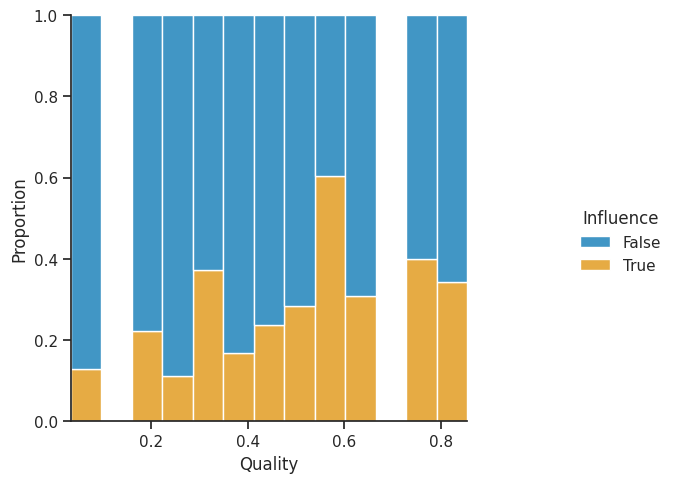

In [660]:
set_theme(
    style="ticks",
    palette="colorblind",
    font_scale=1.0,
    font="sans-serif",
)
df_plot = df_doc.copy()
plot = displot(
    df_plot,
    x="quality_score_document",
    hue="influence_document",
    multiple="fill",
)
plot.set_xlabels("Quality")
plot.set_ylabels("Proportion")
plot.legend.set_title("Influence")
plot

/home/heinrich/Repositories/algorithmic-quality-decision-making/venv/lib/python3.11/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/heinrich/Repositories/algorithmic-quality-decision-making/venv/lib/python3.11/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/heinrich/Repositories/algorithmic-quality-decision-making/venv/lib/python3.11/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)

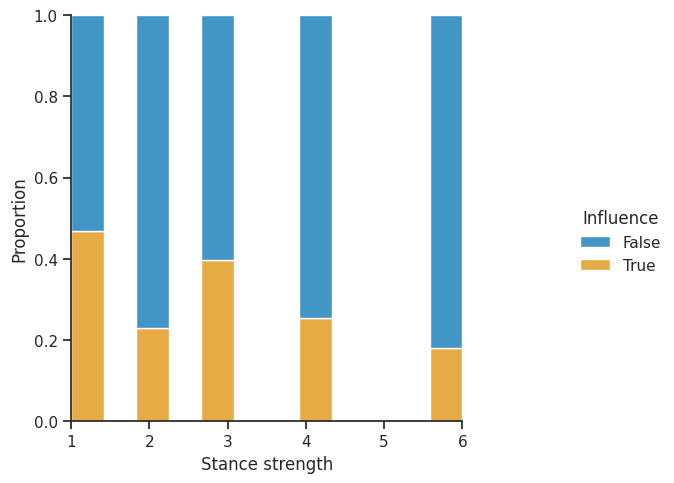

In [661]:
set_theme(
    style="ticks",
    palette="colorblind",
    font_scale=1.0,
    font="sans-serif",
)
df_plot = df_doc.copy()
df_plot = df_plot[df_plot["stance_document"].notna()]
plot = displot(
    df_plot,
    x="stance_document",
    hue="influence_document",
    multiple="fill",
)
plot.set_xlabels("Stance strength")
plot.set_ylabels("Proportion")
plot.legend.set_title("Influence")
plot

/home/heinrich/Repositories/algorithmic-quality-decision-making/venv/lib/python3.11/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/heinrich/Repositories/algorithmic-quality-decision-making/venv/lib/python3.11/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/heinrich/Repositories/algorithmic-quality-decision-making/venv/lib/python3.11/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)

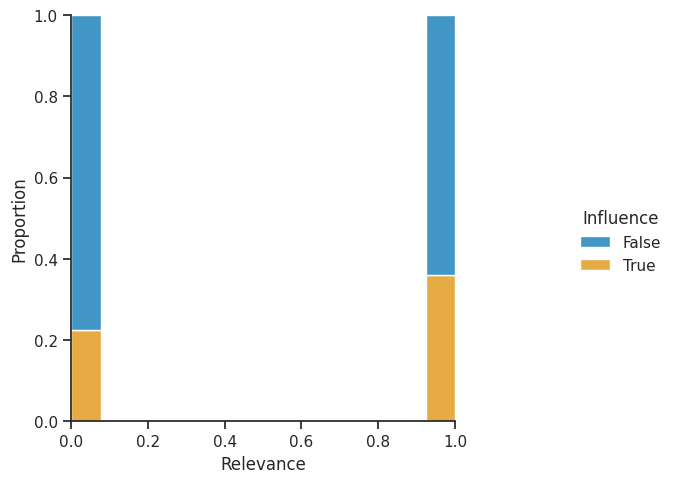

In [662]:
set_theme(
    style="ticks",
    palette="colorblind",
    font_scale=1.0,
    font="sans-serif",
)
df_plot = df_doc.copy()
# df_plot["relevance_document"] = df_plot["relevance_document"].map(
#     lambda x: "relevant" if x else "irrelevant")
plot = displot(
    df_plot,
    x="relevance_document",
    hue="influence_document",
    multiple="fill",
)
plot.set_xlabels("Relevance")
plot.set_ylabels("Proportion")
plot.legend.set_title("Influence")
plot

/home/heinrich/Repositories/algorithmic-quality-decision-making/venv/lib/python3.11/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/heinrich/Repositories/algorithmic-quality-decision-making/venv/lib/python3.11/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/heinrich/Repositories/algorithmic-quality-decision-making/venv/lib/python3.11/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)

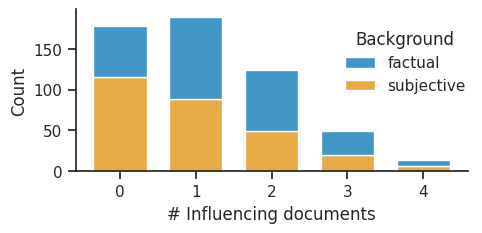

In [663]:
set_theme(
    style="ticks",
    palette="colorblind",
    font_scale=1.0,
    font="sans-serif",
)
df_plot = df.copy()
df_plot.sort_values("num_influencing_documents", inplace=True)
df_plot["num_influencing_documents"] = df_plot["num_influencing_documents"].astype(str)
plot = displot(
    df_plot,
    x="num_influencing_documents",
    hue="background",
    multiple="stack",
    aspect=2,
    height=2.5,
    shrink=0.7,
)
plot.set_xlabels("# Influencing documents")
move_legend(
    plot,
    title="Background",
    loc="upper right",
    bbox_to_anchor=(0.77, 0.9),
)
plot.savefig("../data/figures/histogram-num-influencing-documents.pdf")
plot

## Significance tests

In [664]:
def chi2_to_tex(chi2_result: Chi2ContingencyResult, alpha: float, p_value_digits: int = 3) -> str:
    statistic, p_value, dof, _ = chi2_result
    is_significant = p_value < alpha
    statistic_tex = r"\chi^2(" + f"{dof}" + r")" + f"={statistic:.2f}"
    min_p_value = pow(10, -p_value_digits)
    p_value_tex = format(max(p_value, min_p_value), f".{p_value_digits}f")
    significance_tex = r"p" + ("=" if p_value >= min_p_value else "<") + p_value_tex
    if is_significant:
        statistic_tex = r"\bm{" + statistic_tex + r"}"
        significance_tex = r"\bm{" + significance_tex + r"}"
    tex = r"\(" + statistic_tex + r"\), \(" + significance_tex + r"\)"
    if is_significant:
        tex = r"\textbfn{" + tex + r"}"
    return tex

In [665]:
def diff_expected_freq_tex(row: Series, col: str, index: str, i: int, chi2_result: Chi2ContingencyResult) -> str:
    if index == r"\(\sum\)":
        return ""
    col_index = row.index.get_loc(col)
    diff_expected_freq = (row[col] - chi2_result.expected_freq[i,col_index]).round()
    diff_expected_freq_sign = r"\(+\)" if diff_expected_freq > 0 else r"--" if diff_expected_freq < 0 else r"\(\pm\)"
    diff_expected_freq_tex = f"{diff_expected_freq_sign}{abs(diff_expected_freq):.0f}"
    diff_expected_freq_tex = r"\secondary{(" + diff_expected_freq_tex + r")}"
    return diff_expected_freq_tex

In [666]:
# Copy-pasted from the quality assessments evaluation notebook (median).
quality_threshold = 0.56969696969697
label_low_quality = r"low quality~\secondary{(\(<" + f"{quality_threshold:.2f}" + r"\))}"
label_high_quality = r"high quality~\secondary{(\(\geq" + f"{quality_threshold:.2f}" + r"\))}"
quality_threshold

0.56969696969697

In [667]:
initial_confidence_threshold = df["confidence_before_search"].median()
label_low_initial_confidence = r"low confidence~\secondary{(\(<" + f"{initial_confidence_threshold:.0f}" + r"\))}"
label_high_initial_confidence = r"high confidence~\secondary{(\(\geq" + f"{initial_confidence_threshold:.0f}" + r"\))}"
initial_confidence_threshold

5.0

In [668]:
final_confidence_threshold = df["confidence_after_search"].median()
label_low_final_confidence = r"low confidence~\secondary{(\(<" + f"{final_confidence_threshold:.0f}" + r"\))}"
label_high_final_confidence = r"high confidence~\secondary{(\(\geq" + f"{final_confidence_threshold:.0f}" + r"\))}"
final_confidence_threshold

5.0

In [669]:
df_test = df_doc.copy()
df_test = df_test[df_test["has_partially_read_document"]]
df_test["influence_document"] = df_test["influence_document"].map(
    lambda x: "influence" if x else "no influence")
df_test["influence_document"] = Categorical(
    df_test["influence_document"],
    categories=["no influence", "influence"],
    ordered=True,
)
df_test["quality_document"] = df_test["quality_score_document"].map(
    lambda x: label_high_quality if x >= quality_threshold else label_low_quality)
df_test["quality_document"] = Categorical(
    df_test["quality_document"],
    categories=[label_low_quality, label_high_quality],
    ordered=True,
)
df_test["relevance_document"] = df_test["relevance_document"].map(
    lambda x: "relevant" if x else "not relevant")
df_test["relevance_document"] = Categorical(
    df_test["relevance_document"],
    categories=["not relevant", "relevant"],
    ordered=True,
)
df_test["relevance_quality_document"] = [
    row["relevance_document"] + ", " + row["quality_document"]
    for _, row in df_test.iterrows()
]
df_test["relevance_quality_document"] = Categorical(
    df_test["relevance_quality_document"],
    categories=[f"not relevant, {label_low_quality}", f"not relevant, {label_high_quality}", f"relevant, {label_low_quality}", f"relevant, {label_high_quality}"],
    ordered=True,
)
df_test["stance_strength_document"] = df_test["stance_strength_document"].map({
    0: "no stance",
    1: "weak stance",
    2: "strong stance",
})
df_test["stance_strength_document"] = Categorical(
    df_test["stance_strength_document"],
    categories=["no stance", "weak stance", "strong stance"],
    ordered=True,
)
df_test["initial_confidence"] = df_test["confidence_before_search"].map(
    lambda x: label_high_initial_confidence if x >= initial_confidence_threshold else label_low_initial_confidence)
df_test["initial_confidence"] = Categorical(
    df_test["initial_confidence"],
    categories=[label_low_initial_confidence, label_high_initial_confidence],
    ordered=True,
)
df_test["final_confidence"] = df_test["confidence_after_search"].map(
    lambda x: label_high_final_confidence if x >= final_confidence_threshold else label_low_final_confidence)
df_test["final_confidence"] = Categorical(
    df_test["final_confidence"],
    categories=[label_low_final_confidence, label_high_final_confidence],
    ordered=True,
)
df_test["initial_confidence_low_quality"] = df_test["initial_confidence"].where(
    df_test["quality_document"] == label_low_quality)
df_test["rank"] = "rank~" + df_test["rank"].astype(str)
df_test

,survey_id,qid,background,rank,decision_before_search_object1,decision_before_search_object2,decision_before_search_none,confidence_before_search,decision_after_search_object1,decision_after_search_object2,...,statement_research_confirmed,statement_research_continue,statement_research_helped,statement_research_learned,statement_research_not_helped,quality_document,relevance_quality_document,initial_confidence,final_confidence,initial_confidence_low_quality
0,0,28,factual,rank~1,False,False,True,3.0,False,False,...,False,False,False,False,True,low quality~\secondary{(\(<0.57\))},"not relevant, low quality~\secondary{(\(<0.57\))}",low confidence~\secondary{(\(<5\))},low confidence~\secondary{(\(<5\))},low confidence~\secondary{(\(<5\))}
2,0,28,factual,rank~3,False,False,True,3.0,False,False,...,False,False,False,False,True,low quality~\secondary{(\(<0.57\))},"relevant, low quality~\secondary{(\(<0.57\))}",low confidence~\secondary{(\(<5\))},low confidence~\secondary{(\(<5\))},low confidence~\secondary{(\(<5\))}
0,1,28,factual,rank~1,True,False,False,4.0,False,False,...,False,True,True,True,False,low quality~\secondary{(\(<0.57\))},"not relevant, low quality~\secondary{(\(<0.57\))}",low confidence~\secondary{(\(<5\))},high confidence~\secondary{(\(\geq5\))},low confidence~\secondary{(\(<5\))}
1,1,28,factual,rank~2,True,False,False,4.0,False,False,...,False,True,True,True,False,low quality~\secondary{(\(<0.57\))},"relevant, low quality~\secondary{(\(<0.57\))}",low confidence~\secondary{(\(<5\))},high confidence~\secondary{(\(\geq5\))},low confidence~\secondary{(\(<5\))}
2,1,28,factual,rank~3,True,False,False,4.0,False,False,...,False,True,True,True,False,low quality~\secondary{(\(<0.57\))},"relevant, low quality~\secondary{(\(<0.57\))}",low confidence~\secondary{(\(<5\))},high confidence~\secondary{(\(\geq5\))},low confidence~\secondary{(\(<5\))}
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3,552,10,factual,rank~4,True,False,False,4.0,True,False,...,True,False,True,False,False,low quality~\secondary{(\(<0.57\))},"relevant, low quality~\secondary{(\(<0.57\))}",low confidence~\secondary{(\(<5\))},high confidence~\secondary{(\(\geq5\))},low confidence~\secondary{(\(<5\))}
0,553,10,factual,rank~1,True,False,False,1.0,True,False,...,False,False,False,True,False,high quality~\secondary{(\(\geq0.57\))},"relevant, high quality~\secondary{(\(\geq0.57\))}",low confidence~\secondary{(\(<5\))},low confidence~\secondary{(\(<5\))},NaN
1,553,10,factual,rank~2,True,False,False,1.0,True,False,...,False,False,False,True,False,high quality~\secondary{(\(\geq0.57\))},"relevant, high quality~\secondary{(\(\geq0.57\))}",low confidence~\secondary{(\(<5\))},low confidence~\secondary{(\(<5\))},NaN
2,553,10,factual,rank~3,True,False,False,1.0,True,False,...,False,False,False,True,False,low quality~\secondary{(\(<0.57\))},"not relevant, low quality~\secondary{(\(<0.57\))}",low confidence~\secondary{(\(<5\))},low confidence~\secondary{(\(<5\))},low confidence~\secondary{(\(<5\))}


In [670]:
contingency_quality = crosstab(
    index=df_test["quality_document"],
    columns=df_test["influence_document"],
)
contingency_full_quality = crosstab(
    index=df_test["quality_document"],
    columns=df_test["influence_document"],
    margins=True,
)
contingency_full_quality

influence_document,no influence,influence,All
quality_document,,,
low quality~\secondary{(\(<0.57\))},648,252,900
high quality~\secondary{(\(\geq0.57\))},492,374,866
All,1140,626,1766


In [671]:
chi2_quality = chi2_contingency(contingency_full_quality)
chi2_quality

Chi2ContingencyResult(statistic=44.485628682305716, pvalue=5.0857754705797445e-09, dof=4, expected_freq=array([[ 580.97395243,  319.02604757,  900.        ],
       [ 559.02604757,  306.97395243,  866.        ],
       [1140.        ,  626.        , 1766.        ]]))

In [672]:
contingency_relevance = crosstab(
    index=df_test["relevance_document"],
    columns=df_test["influence_document"],
)
contingency_full_relevance = crosstab(
    index=df_test["relevance_document"],
    columns=df_test["influence_document"],
    margins=True,
)
contingency_full_relevance

influence_document,no influence,influence,All
relevance_document,,,
not relevant,649,255,904
relevant,491,371,862
All,1140,626,1766


In [673]:
chi2_relevance = chi2_contingency(contingency_relevance)
chi2_relevance

Chi2ContingencyResult(statistic=41.772887579013315, pvalue=1.0251515346927013e-10, dof=1, expected_freq=array([[583.55605889, 320.44394111],
       [556.44394111, 305.55605889]]))

In [674]:
contingency_quality_quality_relevance = crosstab(
    index=df_test["relevance_quality_document"],
    columns=df_test["influence_document"],
)
contingency_full_quality_relevance = crosstab(
    index=df_test["relevance_quality_document"],
    columns=df_test["influence_document"],
    margins=True,
)
contingency_full_quality_relevance

influence_document,no influence,influence,All
relevance_quality_document,,,
"not relevant, low quality~\secondary{(\(<0.57\))}",390,113,503
"not relevant, high quality~\secondary{(\(\geq0.57\))}",259,142,401
"relevant, low quality~\secondary{(\(<0.57\))}",258,139,397
"relevant, high quality~\secondary{(\(\geq0.57\))}",233,232,465
All,1140,626,1766


In [675]:
chi2_quality_relevance = chi2_contingency(contingency_full_quality_relevance)
chi2_quality_relevance

Chi2ContingencyResult(statistic=79.4839612057026, pvalue=6.209395338851014e-14, dof=8, expected_freq=array([[ 324.69988675,  178.30011325,  503.        ],
       [ 258.85617214,  142.14382786,  401.        ],
       [ 256.27406569,  140.72593431,  397.        ],
       [ 300.16987542,  164.83012458,  465.        ],
       [1140.        ,  626.        , 1766.        ]]))

In [676]:
contingency_stance_strength = crosstab(
    index=df_test["stance_strength_document"],
    columns=df_test["influence_document"],
)
contingency_full_stance_strength = crosstab(
    index=df_test["stance_strength_document"],
    columns=df_test["influence_document"],
    margins=True,
)
contingency_full_stance_strength

influence_document,no influence,influence,All
stance_strength_document,,,
no stance,273,237,510
weak stance,111,45,156
strong stance,75,99,174
All,459,381,840


In [677]:
chi2_stance_strength = chi2_contingency(contingency_stance_strength)
chi2_stance_strength

Chi2ContingencyResult(statistic=26.76249936372428, pvalue=1.543821561739049e-06, dof=2, expected_freq=array([[278.67857143, 231.32142857],
       [ 85.24285714,  70.75714286],
       [ 95.07857143,  78.92142857]]))

In [678]:
contingency_initial_confidence_low_quality = crosstab(
    index=df_test["initial_confidence_low_quality"],
    columns=df_test["influence_document"],
)
contingency_full_initial_confidence_low_quality = crosstab(
    index=df_test["initial_confidence_low_quality"],
    columns=df_test["influence_document"],
    margins=True,
)
contingency_full_initial_confidence_low_quality

influence_document,no influence,influence,All
initial_confidence_low_quality,,,
low confidence~\secondary{(\(<5\))},302,138,440
high confidence~\secondary{(\(\geq5\))},346,114,460
All,648,252,900


In [679]:
chi2_initial_confidence_low_quality = chi2_contingency(contingency_initial_confidence_low_quality)
chi2_initial_confidence_low_quality

Chi2ContingencyResult(statistic=4.510384316770191, pvalue=0.03368967019978816, dof=1, expected_freq=array([[316.8, 123.2],
       [331.2, 128.8]]))

In [680]:
contingency_rank = crosstab(
    index=df_test["rank"],
    columns=df_test["influence_document"],
)
contingency_full_rank = crosstab(
    index=df_test["rank"],
    columns=df_test["influence_document"],
    margins=True,
)
contingency_full_rank

influence_document,no influence,influence,All
rank,,,
rank~1,286,197,483
rank~2,302,166,468
rank~3,281,144,425
rank~4,271,119,390
All,1140,626,1766


In [681]:
chi2_rank = chi2_contingency(contingency_rank)
chi2_rank

Chi2ContingencyResult(statistic=10.622856219043383, pvalue=0.013950237976468034, dof=3, expected_freq=array([[311.78935447, 171.21064553],
       [302.10645527, 165.89354473],
       [274.34881087, 150.65118913],
       [251.75537939, 138.24462061]]))

In [682]:
tests = [
    (r"Quality", contingency_full_quality, chi2_quality),
    (r"Relevance", contingency_full_relevance, chi2_relevance),
    (r"Quality\,\(\times\)\,relevance", contingency_full_quality_relevance, chi2_quality_relevance),
    (r"Stance strength", contingency_full_stance_strength, chi2_stance_strength),
    (r"Initial confidence (for low-quality docs.)", contingency_full_initial_confidence_low_quality, chi2_initial_confidence_low_quality),
    (r"Ranking position", contingency_full_rank, chi2_rank),
]
alpha = 0.05
correction = 1
alpha_corrected = alpha / correction  # Bonferroni correction across outcomes
# TODO: Indicate change compared to expected frequencies.
print(r"\begin{tabular}{@{}l@{\hspace{\largetabcolsep}}r@{ }lr@{ }lr@{}}")
print(r"  \toprule")
print(r"  \textbf{Predictor} & \multicolumn{5}{@{}c@{}}{\textbf{Document influence}} \\")
print(r"  & \multicolumn{2}{@{}l}{No influence} & \multicolumn{2}{l}{Influence} & \(\sum\) \\")
for variable_name, contingency, chi2_result in tests:
    print(r"  \midrule")
    print(r"  \textit{" + variable_name + r"} & \multicolumn{5}{@{}c@{}}{" +
          chi2_to_tex(chi2_result, alpha_corrected) + r"} \\")
    print(r"  \midrule")
    for i, (index, row) in enumerate(contingency.iterrows()):
        if isinstance(index, tuple):
            index = ", ".join(index)
        elif "All" in index:
            index = r"\(\sum\)"
        columns = [
            index,
            f"{row['no influence']}",
            diff_expected_freq_tex(row, "no influence", index, i, chi2_result),
            f"{row['influence']}",
            diff_expected_freq_tex(row, "influence", index, i, chi2_result),
            f"{row['All']}",
        ]
        print(r"  " + r" & ".join(columns) + r" \\")
print(r"  \bottomrule")
print(r"\end{tabular}")

\begin{tabular}{@{}l@{\hspace{\largetabcolsep}}r@{ }lr@{ }lr@{}}
  \toprule
  \textbf{Predictor} & \multicolumn{5}{@{}c@{}}{\textbf{Document influence}} \\
  & \multicolumn{2}{@{}l}{No influence} & \multicolumn{2}{l}{Influence} & \(\sum\) \\
  \midrule
  \textit{Quality} & \multicolumn{5}{@{}c@{}}{\textbfn{\(\bm{\chi^2(4)=44.49}\), \(\bm{p<0.001}\)}} \\
  \midrule
  low quality~\secondary{(\(<0.57\))} & 648 & \secondary{(\(+\)67)} & 252 & \secondary{(--67)} & 900 \\
  high quality~\secondary{(\(\geq0.57\))} & 492 & \secondary{(--67)} & 374 & \secondary{(\(+\)67)} & 866 \\
  \(\sum\) & 1140 &  & 626 &  & 1766 \\
  \midrule
  \textit{Relevance} & \multicolumn{5}{@{}c@{}}{\textbfn{\(\bm{\chi^2(1)=41.77}\), \(\bm{p<0.001}\)}} \\
  \midrule
  not relevant & 649 & \secondary{(\(+\)65)} & 255 & \secondary{(--65)} & 904 \\
  relevant & 491 & \secondary{(--65)} & 371 & \secondary{(\(+\)65)} & 862 \\
  \(\sum\) & 1140 &  & 626 &  & 1766 \\
  \midrule
  \textit{Quality\,\(\times\)\,relevance} & \

In [683]:
df_test2 = df.copy()
df_test2["decision_changed"] = df_test2["decision_changed"].map(
    lambda x: "changed decision" if x else "same decision")
df_test2["decision_changed"] = Categorical(
    df_test2["decision_changed"],
    categories=["same decision", "changed decision"],
    ordered=True,
)
df_test2["final_confidence"] = df_test2["confidence_after_search"].map(
    lambda x: label_high_final_confidence if x >= final_confidence_threshold else label_low_final_confidence)
df_test2["final_confidence"] = Categorical(
    df_test2["final_confidence"],
    categories=[label_low_final_confidence, label_high_final_confidence],
    ordered=True,
)
df_test2["confidence_changed"] = df_test2["confidence_delta"].map(
    lambda x: nan if isnan(x) else "less confident" if x < 0 else "more confident" if x > 0 else "same confidence")
df_test2["confidence_changed"] = Categorical(
    df_test2["confidence_changed"],
    categories=["less confident", "same confidence", "more confident"],
    ordered=True,
)
df_test2["quality"] = df_test2["quality_score"].map(
    lambda x: label_high_quality if x >= quality_threshold else label_low_quality)
df_test2["quality"] = Categorical(
    df_test2["quality"],
    categories=[label_low_quality, label_high_quality],
    ordered=True,
)
df_test2["background"] = Categorical(
    df_test2["background"],
    categories=["factual", "subjective"],
    ordered=True,
)
for col in (
        "statement_research_confirmed",
        "statement_research_helped",
        "statement_research_not_helped",
        "statement_research_learned",
        "statement_research_continue",
            ):
    df_test2[col]=    df_test2[col].map({True: "yes", False: "no"})
    df_test2[col] = Categorical(
        df_test2[col],
        categories=["no", "yes"],
        ordered=True,
    )
df_test2

,survey_id,qid,prior_knowledge,confidence_before_search,confidence_after_search,quality_score,quality_score_document1,quality_score_document2,quality_score_document3,quality_score_document4,...,decision_before_search_none,decision_after_search_none,confidence_delta,decision_unchanged,decision_changed,num_influencing_documents,relevance,final_confidence,confidence_changed,quality
0,0,28,False,3.0,3.0,0.322727,0.251515,0.372727,0.293939,0.372727,...,True,True,0.0,True,same decision,0,0.75,low confidence~\secondary{(\(<5\))},same confidence,low quality~\secondary{(\(<0.57\))}
1,1,28,False,4.0,5.0,0.322727,0.251515,0.372727,0.293939,0.372727,...,False,True,1.0,False,changed decision,2,0.75,high confidence~\secondary{(\(\geq5\))},more confident,low quality~\secondary{(\(<0.57\))}
2,2,28,False,3.0,3.0,0.322727,0.251515,0.372727,0.293939,0.372727,...,True,True,0.0,True,same decision,0,0.75,low confidence~\secondary{(\(<5\))},same confidence,low quality~\secondary{(\(<0.57\))}
3,3,28,False,1.0,3.0,0.322727,0.251515,0.372727,0.293939,0.372727,...,True,True,2.0,True,same decision,0,0.75,low confidence~\secondary{(\(<5\))},more confident,low quality~\secondary{(\(<0.57\))}
4,4,28,True,3.0,6.0,0.322727,0.251515,0.372727,0.293939,0.372727,...,False,True,3.0,False,changed decision,1,0.75,high confidence~\secondary{(\(\geq5\))},more confident,low quality~\secondary{(\(<0.57\))}
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
549,549,10,False,6.0,4.0,0.503788,0.581818,0.739394,0.521212,0.172727,...,True,False,-2.0,False,changed decision,3,0.75,low confidence~\secondary{(\(<5\))},less confident,low quality~\secondary{(\(<0.57\))}
550,550,10,False,5.0,6.0,0.503788,0.581818,0.739394,0.521212,0.172727,...,False,False,1.0,False,changed decision,1,0.75,high confidence~\secondary{(\(\geq5\))},more confident,low quality~\secondary{(\(<0.57\))}
551,551,10,False,2.0,3.0,0.503788,0.581818,0.739394,0.521212,0.172727,...,False,False,1.0,True,same decision,2,0.75,low confidence~\secondary{(\(<5\))},more confident,low quality~\secondary{(\(<0.57\))}
552,552,10,True,4.0,6.0,0.503788,0.581818,0.739394,0.521212,0.172727,...,False,False,2.0,True,same decision,4,0.75,high confidence~\secondary{(\(\geq5\))},more confident,low quality~\secondary{(\(<0.57\))}


In [684]:
contingency_background_decision_change = crosstab(
    index=df_test2["background"],
    columns=df_test2["decision_changed"],
)
contingency_full_background_decision_change = crosstab(
    index=df_test2["background"],
    columns=df_test2["decision_changed"],
    margins=True,
)
contingency_full_background_decision_change

decision_changed,same decision,changed decision,All
background,,,
factual,173,101,274
subjective,168,112,280
All,341,213,554


In [685]:
chi2_background_decision_change = chi2_contingency(contingency_background_decision_change)
chi2_background_decision_change

Chi2ContingencyResult(statistic=0.45147539596089975, pvalue=0.5016351438413066, dof=1, expected_freq=array([[168.6534296, 105.3465704],
       [172.3465704, 107.6534296]]))

In [686]:
contingency_quality_decision_change = crosstab(
    index=df_test2["quality"],
    columns=df_test2["decision_changed"],
)
contingency_full_quality_decision_change = crosstab(
    index=df_test2["quality"],
    columns=df_test2["decision_changed"],
    margins=True,
)
contingency_full_quality_decision_change

decision_changed,same decision,changed decision,All
quality,,,
low quality~\secondary{(\(<0.57\))},154,119,273
high quality~\secondary{(\(\geq0.57\))},187,94,281
All,341,213,554


In [687]:
chi2_quality_decision_change = chi2_contingency(contingency_quality_decision_change)
chi2_quality_decision_change

Chi2ContingencyResult(statistic=5.5928006827064305, pvalue=0.018034438809805656, dof=1, expected_freq=array([[168.03790614, 104.96209386],
       [172.96209386, 108.03790614]]))

In [688]:
contingency_background_final_confidence = crosstab(
    index=df_test2["background"],
    columns=df_test2["final_confidence"],
)
contingency_full_background_final_confidence = crosstab(
    index=df_test2["background"],
    columns=df_test2["final_confidence"],
    margins=True,
)
contingency_full_background_final_confidence

final_confidence,low confidence~\secondary{(\(<5\))},high confidence~\secondary{(\(\geq5\))},All
background,,,
factual,93,181,274
subjective,117,163,280
All,210,344,554


In [689]:
chi2_background_final_confidence = chi2_contingency(contingency_background_final_confidence)
chi2_background_final_confidence

Chi2ContingencyResult(statistic=3.2945683881471437, pvalue=0.06950937370879164, dof=1, expected_freq=array([[103.86281588, 170.13718412],
       [106.13718412, 173.86281588]]))

In [690]:
contingency_quality_final_confidence = crosstab(
    index=df_test2["quality"],
    columns=df_test2["final_confidence"],
)
contingency_full_quality_final_confidence = crosstab(
    index=df_test2["quality"],
    columns=df_test2["final_confidence"],
    margins=True,
)
contingency_full_quality_final_confidence

final_confidence,low confidence~\secondary{(\(<5\))},high confidence~\secondary{(\(\geq5\))},All
quality,,,
low quality~\secondary{(\(<0.57\))},105,168,273
high quality~\secondary{(\(\geq0.57\))},105,176,281
All,210,344,554


In [691]:
chi2_quality_final_confidence = chi2_contingency(contingency_quality_final_confidence)
chi2_quality_final_confidence

Chi2ContingencyResult(statistic=0.03168690707056254, pvalue=0.8587165628284373, dof=1, expected_freq=array([[103.48375451, 169.51624549],
       [106.51624549, 174.48375451]]))

In [692]:
contingency_background_confidence_change = crosstab(
    index=df_test2["background"],
    columns=df_test2["confidence_changed"],
)
contingency_full_background_confidence_change = crosstab(
    index=df_test2["background"],
    columns=df_test2["confidence_changed"],
    margins=True,
)
contingency_full_background_confidence_change

confidence_changed,less confident,same confidence,more confident,All
background,,,,
factual,46,98,121,265
subjective,50,146,78,274
All,96,244,199,539


In [693]:
chi2_background_confidence_change = chi2_contingency(contingency_background_confidence_change)
chi2_background_confidence_change

Chi2ContingencyResult(statistic=18.75569787657797, pvalue=8.457693721328121e-05, dof=2, expected_freq=array([[ 47.19851577, 119.96289425,  97.83858998],
       [ 48.80148423, 124.03710575, 101.16141002]]))

In [694]:
contingency_quality_confidence_change = crosstab(
    index=df_test2["quality"],
    columns=df_test2["confidence_changed"],
)
contingency_full_quality_confidence_change = crosstab(
    index=df_test2["quality"],
    columns=df_test2["confidence_changed"],
    margins=True,
)
contingency_full_quality_confidence_change

confidence_changed,less confident,same confidence,more confident,All
quality,,,,
low quality~\secondary{(\(<0.57\))},49,132,87,268
high quality~\secondary{(\(\geq0.57\))},47,112,112,271
All,96,244,199,539


In [695]:
chi2_quality_confidence_change = chi2_contingency(contingency_quality_confidence_change)
chi2_quality_confidence_change

Chi2ContingencyResult(statistic=4.805165716824304, pvalue=0.09048394399715304, dof=2, expected_freq=array([[ 47.73283859, 121.32096475,  98.94619666],
       [ 48.26716141, 122.67903525, 100.05380334]]))

In [696]:
contingency_decision_confidence_change = crosstab(
    index=df_test2["decision_changed"],
    columns=df_test2["confidence_changed"],
)
contingency_full_decision_confidence_change = crosstab(
    index=df_test2["decision_changed"],
    columns=df_test2["confidence_changed"],
    margins=True,
)
contingency_full_decision_confidence_change

confidence_changed,less confident,same confidence,more confident,All
decision_changed,,,,
same decision,38,182,115,335
changed decision,58,62,84,204
All,96,244,199,539


In [697]:
chi2_decision_confidence_change = chi2_contingency(contingency_decision_confidence_change)
chi2_decision_confidence_change

Chi2ContingencyResult(statistic=38.444523896115314, pvalue=4.486190447261729e-09, dof=2, expected_freq=array([[ 59.66604824, 151.65120594, 123.68274583],
       [ 36.33395176,  92.34879406,  75.31725417]]))

In [698]:
tests = [
    (r"Background", contingency_full_background_decision_change, chi2_background_decision_change, contingency_full_background_final_confidence, chi2_background_final_confidence, contingency_full_background_confidence_change, chi2_background_confidence_change),
    (r"Quality", contingency_full_quality_decision_change, chi2_quality_decision_change, contingency_full_quality_final_confidence, chi2_quality_final_confidence, contingency_full_quality_confidence_change, chi2_quality_confidence_change),
]
alpha = 0.05
correction = 3
alpha_corrected = alpha / correction  # Bonferroni correction across outcomes
# TODO: Indicate change compared to expected frequencies.
# print(r"\newlength{\largetabcolsep}")
# print(r"\setlength{\largetabcolsep}{3\tabcolsep}")
print(r"\begin{tabular}{@{}l@{\hspace{\largetabcolsep}}r@{ }lr@{ }lr@{\hspace{\largetabcolsep}}r@{ }lr@{ }lr@{\hspace{\largetabcolsep}}r@{ }lr@{ }lr@{ }lr@{}}")
print(r"  \toprule")
print(r"  \textbf{Predictor} & \multicolumn{5}{@{}c@{\hspace{\largetabcolsep}}}{\textbf{Decision change}} & \multicolumn{5}{@{}c@{\hspace{\largetabcolsep}}}{\textbf{Final decision confidence}} & \multicolumn{7}{@{}c@{}}{\textbf{Decision confidence change}} \\")
print(r"  & \multicolumn{2}{@{}l}{Unchanged} & \multicolumn{2}{l}{Changed} & \(\sum\) & \multicolumn{2}{@{}l}{Low~\secondary{(\(<"+f"{final_confidence_threshold:.2f}"+r"\))}} & \multicolumn{2}{l}{High~\secondary{(\(<"+f"{final_confidence_threshold:.2f}"+r"\))}} & \(\sum\) & \multicolumn{2}{@{}l}{Decreased} & \multicolumn{2}{l}{Unchanged} & \multicolumn{2}{l}{Increased} & \(\sum\) \\")
for variable_name, contingency_decision_change, chi2_result_decision_change, contingency_final_confidence, chi2_result_final_confidence, contingency_confidence_change, chi2_result_confidence_change in tests:
    print(r"  \midrule")
    print(r"  \textit{" + variable_name + r"} & \multicolumn{5}{@{}c@{\hspace{\largetabcolsep}}}{" + chi2_to_tex(chi2_result_decision_change, alpha_corrected) + r"} & \multicolumn{5}{@{}c@{\hspace{\largetabcolsep}}}{" + chi2_to_tex(chi2_result_final_confidence, alpha_corrected) + r"} & \multicolumn{7}{@{}c@{}}{" + chi2_to_tex(chi2_result_confidence_change, alpha_corrected) + r"} \\")
    print(r"  \midrule")
    for i, ((index_decision_change, row_decision_change), (index_final_confidence, row_final_confidence), (index_confidence_change, row_confidence_change)) in enumerate(zip(contingency_decision_change.iterrows(), contingency_final_confidence.iterrows(), contingency_confidence_change.iterrows())):
        assert index_decision_change == index_final_confidence == index_confidence_change
        index = index_confidence_change
        if "All" in index:
            index = r"\(\sum\)"
        columns = [
            index,
            f"{row_decision_change['same decision']}",
            diff_expected_freq_tex(row_decision_change, "same decision", index, i, chi2_result_decision_change),
            f"{row_decision_change['changed decision']}",
            diff_expected_freq_tex(row_decision_change, "changed decision", index, i, chi2_result_decision_change),
            f"{row_decision_change['All']}",
            f"{row_final_confidence[label_low_final_confidence]}",
            diff_expected_freq_tex(row_final_confidence, label_low_final_confidence, index, i, chi2_result_final_confidence),
            f"{row_final_confidence[label_high_final_confidence]}",
            diff_expected_freq_tex(row_final_confidence, label_high_final_confidence, index, i, chi2_result_final_confidence),
            f"{row_final_confidence['All']}",
            f"{row_confidence_change['less confident']}",
            diff_expected_freq_tex(row_confidence_change, "less confident", index, i, chi2_result_confidence_change),
            f"{row_confidence_change['same confidence']}",
            diff_expected_freq_tex(row_confidence_change, "same confidence", index, i, chi2_result_confidence_change),
            f"{row_confidence_change['more confident']}",
            diff_expected_freq_tex(row_confidence_change, "more confident", index, i, chi2_result_confidence_change),
            f"{row_confidence_change['All']}",
        ]
        print(r"  " + r" & ".join(columns) + r" \\")
print(r"  \bottomrule")
print(r"\end{tabular}")

\begin{tabular}{@{}l@{\hspace{\largetabcolsep}}r@{ }lr@{ }lr@{\hspace{\largetabcolsep}}r@{ }lr@{ }lr@{\hspace{\largetabcolsep}}r@{ }lr@{ }lr@{ }lr@{}}
  \toprule
  \textbf{Predictor} & \multicolumn{5}{@{}c@{\hspace{\largetabcolsep}}}{\textbf{Decision change}} & \multicolumn{5}{@{}c@{\hspace{\largetabcolsep}}}{\textbf{Final decision confidence}} & \multicolumn{7}{@{}c@{}}{\textbf{Decision confidence change}} \\
  & \multicolumn{2}{@{}l}{Unchanged} & \multicolumn{2}{l}{Changed} & \(\sum\) & \multicolumn{2}{@{}l}{Low~\secondary{(\(<5.00\))}} & \multicolumn{2}{l}{High~\secondary{(\(<5.00\))}} & \(\sum\) & \multicolumn{2}{@{}l}{Decreased} & \multicolumn{2}{l}{Unchanged} & \multicolumn{2}{l}{Increased} & \(\sum\) \\
  \midrule
  \textit{Background} & \multicolumn{5}{@{}c@{\hspace{\largetabcolsep}}}{\(\chi^2(1)=0.45\), \(p=0.502\)} & \multicolumn{5}{@{}c@{\hspace{\largetabcolsep}}}{\(\chi^2(1)=3.29\), \(p=0.070\)} & \multicolumn{7}{@{}c@{}}{\textbfn{\(\bm{\chi^2(2)=18.76}\), \(\bm{p<0.001}\)}

In [699]:
contingency_statement_research_confirmed = crosstab(
    index=df_test2["quality"],
    columns=df_test2["statement_research_confirmed"],
)
contingency_full_statement_research_confirmed = crosstab(
    index=df_test2["quality"],
    columns=df_test2["statement_research_confirmed"],
    margins=True,
)
contingency_full_statement_research_confirmed

statement_research_confirmed,no,yes,All
quality,,,
low quality~\secondary{(\(<0.57\))},215,58,273
high quality~\secondary{(\(\geq0.57\))},213,68,281
All,428,126,554


In [700]:
chi2_statement_research_confirmed = chi2_contingency(contingency_statement_research_confirmed)
chi2_statement_research_confirmed

Chi2ContingencyResult(statistic=0.5297805988394619, pvalue=0.46669911488200444, dof=1, expected_freq=array([[210.90974729,  62.09025271],
       [217.09025271,  63.90974729]]))

In [701]:
contingency_statement_research_helped = crosstab(
    index=df_test2["quality"],
    columns=df_test2["statement_research_helped"],
)
contingency_full_statement_research_helped = crosstab(
    index=df_test2["quality"],
    columns=df_test2["statement_research_helped"],
    margins=True,
)
contingency_full_statement_research_helped

statement_research_helped,no,yes,All
quality,,,
low quality~\secondary{(\(<0.57\))},216,57,273
high quality~\secondary{(\(\geq0.57\))},177,104,281
All,393,161,554


In [702]:
chi2_statement_research_helped = chi2_contingency(contingency_statement_research_helped)
chi2_statement_research_helped

Chi2ContingencyResult(statistic=16.705117384774475, pvalue=4.366306089184387e-05, dof=1, expected_freq=array([[193.66245487,  79.33754513],
       [199.33754513,  81.66245487]]))

In [703]:
contingency_statement_research_not_helped = crosstab(
    index=df_test2["quality"],
    columns=df_test2["statement_research_not_helped"],
)
contingency_full_statement_research_not_helped = crosstab(
    index=df_test2["quality"],
    columns=df_test2["statement_research_not_helped"],
    margins=True,
)
contingency_full_statement_research_not_helped

statement_research_not_helped,no,yes,All
quality,,,
low quality~\secondary{(\(<0.57\))},201,72,273
high quality~\secondary{(\(\geq0.57\))},243,38,281
All,444,110,554


In [704]:
chi2_statement_research_not_helped = chi2_contingency(contingency_statement_research_not_helped)
chi2_statement_research_not_helped

Chi2ContingencyResult(statistic=13.573342966759338, pvalue=0.00022942042584097255, dof=1, expected_freq=array([[218.79422383,  54.20577617],
       [225.20577617,  55.79422383]]))

In [705]:
contingency_statement_research_learned = crosstab(
    index=df_test2["quality"],
    columns=df_test2["statement_research_learned"],
)
contingency_full_statement_research_learned = crosstab(
    index=df_test2["quality"],
    columns=df_test2["statement_research_learned"],
    margins=True,
)
contingency_full_statement_research_learned

statement_research_learned,no,yes,All
quality,,,
low quality~\secondary{(\(<0.57\))},168,105,273
high quality~\secondary{(\(\geq0.57\))},112,169,281
All,280,274,554


In [706]:
chi2_statement_research_learned = chi2_contingency(contingency_statement_research_learned)
chi2_statement_research_learned

Chi2ContingencyResult(statistic=25.178699839088498, pvalue=5.225616709624952e-07, dof=1, expected_freq=array([[137.97833935, 135.02166065],
       [142.02166065, 138.97833935]]))

In [707]:
contingency_statement_research_continue = crosstab(
    index=df_test2["quality"],
    columns=df_test2["statement_research_continue"],
)
contingency_full_statement_research_continue = crosstab(
    index=df_test2["quality"],
    columns=df_test2["statement_research_continue"],
    margins=True,
)
contingency_full_statement_research_continue

statement_research_continue,no,yes,All
quality,,,
low quality~\secondary{(\(<0.57\))},193,80,273
high quality~\secondary{(\(\geq0.57\))},233,48,281
All,426,128,554


In [708]:
chi2_statement_research_continue = chi2_contingency(contingency_statement_research_continue)
chi2_statement_research_continue

Chi2ContingencyResult(statistic=10.964998057913595, pvalue=0.0009284904422298395, dof=1, expected_freq=array([[209.92418773,  63.07581227],
       [216.07581227,  64.92418773]]))

In [709]:
contingency_statement_research_confirmed_background = crosstab(
    index=df_test2["background"],
    columns=df_test2["statement_research_confirmed"],
)
contingency_full_statement_research_confirmed_background = crosstab(
    index=df_test2["background"],
    columns=df_test2["statement_research_confirmed"],
    margins=True,
)
contingency_full_statement_research_confirmed_background

statement_research_confirmed,no,yes,All
background,,,
factual,199,75,274
subjective,229,51,280
All,428,126,554


In [710]:
chi2_statement_research_confirmed_background = chi2_contingency(contingency_statement_research_confirmed_background)
chi2_statement_research_confirmed_background

Chi2ContingencyResult(statistic=6.099099419567495, pvalue=0.013525079199060413, dof=1, expected_freq=array([[211.68231047,  62.31768953],
       [216.31768953,  63.68231047]]))

In [711]:
contingency_statement_research_helped_background = crosstab(
    index=df_test2["background"],
    columns=df_test2["statement_research_helped"],
)
contingency_full_statement_research_helped_background = crosstab(
    index=df_test2["background"],
    columns=df_test2["statement_research_helped"],
    margins=True,
)
contingency_full_statement_research_helped_background

statement_research_helped,no,yes,All
background,,,
factual,171,103,274
subjective,222,58,280
All,393,161,554


In [712]:
chi2_statement_research_helped_background = chi2_contingency(contingency_statement_research_helped_background)
chi2_statement_research_helped_background

Chi2ContingencyResult(statistic=18.32333517903541, pvalue=1.8640979363567875e-05, dof=1, expected_freq=array([[194.37184116,  79.62815884],
       [198.62815884,  81.37184116]]))

In [713]:
contingency_statement_research_not_helped_background = crosstab(
    index=df_test2["background"],
    columns=df_test2["statement_research_not_helped"],
)
contingency_full_statement_research_not_helped_background = crosstab(
    index=df_test2["background"],
    columns=df_test2["statement_research_not_helped"],
    margins=True,
)
contingency_full_statement_research_not_helped_background

statement_research_not_helped,no,yes,All
background,,,
factual,227,47,274
subjective,217,63,280
All,444,110,554


In [714]:
chi2_statement_research_not_helped_background = chi2_contingency(contingency_statement_research_not_helped_background)
chi2_statement_research_not_helped_background

Chi2ContingencyResult(statistic=2.1631587581633203, pvalue=0.14135384639055168, dof=1, expected_freq=array([[219.59566787,  54.40433213],
       [224.40433213,  55.59566787]]))

In [715]:
contingency_statement_research_learned_background = crosstab(
    index=df_test2["background"],
    columns=df_test2["statement_research_learned"],
)
contingency_full_statement_research_learned_background = crosstab(
    index=df_test2["background"],
    columns=df_test2["statement_research_learned"],
    margins=True,
)
contingency_full_statement_research_learned_background

statement_research_learned,no,yes,All
background,,,
factual,127,147,274
subjective,153,127,280
All,280,274,554


In [716]:
chi2_statement_research_learned_background = chi2_contingency(contingency_statement_research_learned_background)
chi2_statement_research_learned_background

Chi2ContingencyResult(statistic=3.485087942517573, pvalue=0.061924071044720516, dof=1, expected_freq=array([[138.48375451, 135.51624549],
       [141.51624549, 138.48375451]]))

In [717]:
contingency_statement_research_continue_background = crosstab(
    index=df_test2["background"],
    columns=df_test2["statement_research_continue"],
)
contingency_full_statement_research_continue_background = crosstab(
    index=df_test2["background"],
    columns=df_test2["statement_research_continue"],
    margins=True,
)
contingency_full_statement_research_continue_background

statement_research_continue,no,yes,All
background,,,
factual,208,66,274
subjective,218,62,280
All,426,128,554


In [718]:
chi2_statement_research_continue_background = chi2_contingency(contingency_statement_research_continue_background)
chi2_statement_research_continue_background

Chi2ContingencyResult(statistic=0.1954943263022481, pvalue=0.6583825437223951, dof=1, expected_freq=array([[210.69314079,  63.30685921],
       [215.30685921,  64.69314079]]))

In [719]:
tests = [
    (r"Background", contingency_full_statement_research_confirmed_background, chi2_statement_research_confirmed_background, contingency_full_statement_research_helped_background, chi2_statement_research_helped_background, contingency_full_statement_research_not_helped_background, chi2_statement_research_not_helped_background, contingency_full_statement_research_learned_background, chi2_statement_research_learned_background, contingency_full_statement_research_continue_background, chi2_statement_research_continue_background),
    (r"Quality", contingency_full_statement_research_confirmed, chi2_statement_research_confirmed, contingency_full_statement_research_helped, chi2_statement_research_helped, contingency_full_statement_research_not_helped, chi2_statement_research_not_helped, contingency_full_statement_research_learned, chi2_statement_research_learned, contingency_full_statement_research_continue, chi2_statement_research_continue),
]
alpha = 0.05
correction = 5
alpha_corrected = alpha / correction  # Bonferroni correction across outcomes
# TODO: Indicate change compared to expected frequencies.
# print(r"\newlength{\largetabcolsep}")
# print(r"\setlength{\largetabcolsep}{3\tabcolsep}")
print(r"\begin{tabular}{@{}l@{\hspace{\largetabcolsep}}r@{ }lr@{ }lr@{\hspace{\largetabcolsep}}r@{ }lr@{ }lr@{\hspace{\largetabcolsep}}r@{ }lr@{ }lr@{\hspace{\largetabcolsep}}r@{ }lr@{ }lr@{\hspace{\largetabcolsep}}r@{ }lr@{ }lr@{}}")
print(r"  \toprule")
print(r"  \textbf{Predictor} & \multicolumn{5}{@{}c@{\hspace{\largetabcolsep}}}{\textbf{Confirm.\ prev.\ opinion}} & \multicolumn{5}{@{}c@{\hspace{\largetabcolsep}}}{\textbf{Could make better decis.}} & \multicolumn{5}{@{}c@{\hspace{\largetabcolsep}}}{\textbf{Results did not help}} & \multicolumn{5}{@{}c@{\hspace{\largetabcolsep}}}{\textbf{Learned something new}} & \multicolumn{5}{@{}c@{}}{\textbf{Would do further search}} \\")
print(r"  & \multicolumn{2}{@{}l}{No} & \multicolumn{2}{l}{Yes} & \(\sum\) & \multicolumn{2}{@{}l}{No} & \multicolumn{2}{l}{Yes} & \(\sum\) & \multicolumn{2}{@{}l}{No} & \multicolumn{2}{l}{Yes} & \(\sum\) & \multicolumn{2}{@{}l}{No} & \multicolumn{2}{l}{Yes} & \(\sum\) & \multicolumn{2}{@{}l}{No} & \multicolumn{2}{l}{Yes} & \(\sum\) \\")
for variable_name, contingency_1, chi2_result_1, contingency_2, chi2_result_2, contingency_3, chi2_result_3, contingency_4, chi2_result_4, contingency_5, chi2_result_5 in tests:
    statistic_1, p_value_1, dof_1, _ = chi2_result_1
    statistic_2, p_value_2, dof_2, _ = chi2_result_2
    statistic_3, p_value_3, dof_3, _ = chi2_result_3
    statistic_4, p_value_4, dof_4, _ = chi2_result_4
    statistic_5, p_value_5, dof_5, _ = chi2_result_5
    print(r"  \midrule")
    print(r"  \textit{" + variable_name + r"} & \multicolumn{5}{@{}c@{\hspace{\largetabcolsep}}}{" + chi2_to_tex(chi2_result_1, alpha_corrected) + r"} & \multicolumn{5}{@{}c@{\hspace{\largetabcolsep}}}{" + chi2_to_tex(chi2_result_2, alpha_corrected) + r"} & \multicolumn{5}{@{}c@{\hspace{\largetabcolsep}}}{" + chi2_to_tex(chi2_result_3, alpha_corrected) + r"} & \multicolumn{5}{@{}c@{\hspace{\largetabcolsep}}}{" + chi2_to_tex(chi2_result_4, alpha_corrected) + r"} & \multicolumn{5}{@{}c@{}}{" + chi2_to_tex(chi2_result_5, alpha_corrected) + r"} \\")
    print(r"  \midrule")
    for i, ((index_1, row_1), (index_2, row_2), (index_3, row_3), (index_4, row_4), (index_5, row_5)) in enumerate(zip(contingency_1.iterrows(), contingency_2.iterrows(), contingency_3.iterrows(), contingency_4.iterrows(), contingency_5.iterrows())):
        assert index_1 == index_2 == index_3 == index_4 == index_5
        index = index_1
        if "All" in index:
            index = r"\(\sum\)"
        columns = [
            index,
            f"{row_1['no']}",
            diff_expected_freq_tex(row_1, "no", index, i, chi2_result_1),
            f"{row_1['yes']}",
            diff_expected_freq_tex(row_1, "yes", index, i, chi2_result_1),
            f"{row_1['All']}",
            f"{row_2['no']}",
            diff_expected_freq_tex(row_2, "no", index, i, chi2_result_2),
            f"{row_2['yes']}",
            diff_expected_freq_tex(row_2, "yes", index, i, chi2_result_2),
            f"{row_2['All']}",
            f"{row_3['no']}",
            diff_expected_freq_tex(row_3, "no", index, i, chi2_result_3),
            f"{row_3['yes']}",
            diff_expected_freq_tex(row_3, "yes", index, i, chi2_result_3),
            f"{row_3['All']}",
            f"{row_4['no']}",
            diff_expected_freq_tex(row_4, "no", index, i, chi2_result_4),
            f"{row_4['yes']}",
            diff_expected_freq_tex(row_4, "yes", index, i, chi2_result_4),
            f"{row_4['All']}",
            f"{row_5['no']}",
            diff_expected_freq_tex(row_5, "no", index, i, chi2_result_5),
            f"{row_5['yes']}",
            diff_expected_freq_tex(row_5, "yes", index, i, chi2_result_5),
            f"{row_5['All']}",
        ]
        print(r"  " + r" & ".join(columns) + r" \\")
print(r"  \bottomrule")
print(r"\end{tabular}")

\begin{tabular}{@{}l@{\hspace{\largetabcolsep}}r@{ }lr@{ }lr@{\hspace{\largetabcolsep}}r@{ }lr@{ }lr@{\hspace{\largetabcolsep}}r@{ }lr@{ }lr@{\hspace{\largetabcolsep}}r@{ }lr@{ }lr@{\hspace{\largetabcolsep}}r@{ }lr@{ }lr@{}}
  \toprule
  \textbf{Predictor} & \multicolumn{5}{@{}c@{\hspace{\largetabcolsep}}}{\textbf{Confirm.\ prev.\ opinion}} & \multicolumn{5}{@{}c@{\hspace{\largetabcolsep}}}{\textbf{Could make better decis.}} & \multicolumn{5}{@{}c@{\hspace{\largetabcolsep}}}{\textbf{Results did not help}} & \multicolumn{5}{@{}c@{\hspace{\largetabcolsep}}}{\textbf{Learned something new}} & \multicolumn{5}{@{}c@{}}{\textbf{Would do further search}} \\
  & \multicolumn{2}{@{}l}{No} & \multicolumn{2}{l}{Yes} & \(\sum\) & \multicolumn{2}{@{}l}{No} & \multicolumn{2}{l}{Yes} & \(\sum\) & \multicolumn{2}{@{}l}{No} & \multicolumn{2}{l}{Yes} & \(\sum\) & \multicolumn{2}{@{}l}{No} & \multicolumn{2}{l}{Yes} & \(\sum\) & \multicolumn{2}{@{}l}{No} & \multicolumn{2}{l}{Yes} & \(\sum\) \\
  \midrule
 

In [720]:
alpha_corrected

0.01

## Correlations

In [721]:
pearsonr(df_doc["rank"], df_doc["has_fully_read_document"])

PearsonRResult(statistic=-0.09275506179471997, pvalue=1.2235055812139667e-05)

In [722]:
pearsonr(df_doc["rank"], df_doc["has_partially_read_document"])

PearsonRResult(statistic=-0.16153597711143614, pvalue=2.006463264539391e-14)

In [723]:
pearsonr(df_doc["rank"], df_doc["influence_document"])

PearsonRResult(statistic=-0.1122141037309577, pvalue=1.1825883633989267e-07)

In [724]:
pearsonr(df_doc["rank"], df_doc["quality_score_document"])

PearsonRResult(statistic=-0.2114050356360075, pvalue=8.294865223591813e-24)

In [725]:
pearsonr(df_doc["rank"], df_doc["relevance_document"])

PearsonRResult(statistic=-0.0667272054441804, pvalue=0.0016729751072267378)

In [726]:
pearsonr(df_doc["relevance_document"], df_doc["quality_score_document"])

PearsonRResult(statistic=0.15843226775024727, pvalue=6.317799909298208e-14)